# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lecture 01 - Clustering with Python

**Harvard University**<br>
**Spring 2022**<br>
**Instructors:** Mark Glickman and Pavlos Protopapas<br>
<BR>
**Lab Instructor:** Eleni Kaxiras<br>
**Content:** Eleni Kaxiras, Chris Tanner, and Will Claybaugh

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

%matplotlib inline 

In [3]:
#from gapstatistics import OptimalK
from yellowbrick.cluster import KElbowVisualizer

In [4]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import load_digits
import warnings
warnings.filterwarnings('ignore')

### Learning Objectives

* Understand the common distance metrics (e.g., Euclidean, Manhattan, Hamming).
* Understand the difference between a vector matrix and a distance matrix
* Understand how different clustering algorithms work (e.g., k-means, Hierarchical, DBSCAN).
* For home: Review what PCA is and know the differences between PCA and clustering,

### Table of Contents

1. [PCA Refresher](#pca)
2. [Preparing the data](#prepare)
3. [Choosing a distance or dissimilarity metric](#distance)
4. [Clustering algorithms and measuring the quality of clusters](#clustering)
5. [Extra: Clustering for images](#images)


### Unsupervised Learning, Cluster Analysis, and Classification
<BR>
    <div class="discussion"><b>Review</b>: What is unsupervised learning? What is Cluster Analysis? Is the response variable included in the algorithm? What does it mean to perform classification?</div>
   
<center>
<img src="../images/linear.png" width="500">
<img src="../images/iris.png" width="500">
</center>

<a id=pca></a>   
## 1. PCA Refresher
<center>
<img src="../images/noise.png" width="500">
</center>

*image source: [1]*
<BR><BR>
<div 
class="discussion"><b>Review</b> What is PCA? How can it be useful? What are its limitations?</div>
<center>

<img src="../images/redund.png" width="600">
</center>
    
*image source: [1]*

Sklearn's `sklearn.decomposition.PCA` uses the LAPACK library written in Fortran 90 (based on the LINPACK library from the 70s) which provides routines for solving systems of simultaneous linear equations, least-squares solutions of linear systems of equations.

### How to use the `sklearn` PCA package:

#### a. Instantiate a new PCA object:
`pca_transformer = PCA()`

#### b. Fit some data (learns the transformation based on this data):
`fitted_pca = pca_transformer.fit(data_frame)`

#### c. Transform the data to the reduced dimensions:
`pca_df = fitted_pca.transform(data_frame)`

Using two distinct steps (i.e., (b) and (c)) to fit and transform our data allows one the flexibility to transform any dataset according to our learned `fit()`. Alternatively, if you know you only want to transform a single dataset, you can combine (b) and (c) into one step:
#### Fit and transform:
`pca_df = pca_transformer.fit_transform(pca_df)`

**Note:** We fit on the training set and transform both training and test set.

### Example: Playing with synthetic data

`Sklearn` has methods for [generating synthetic datasets](https://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html). They can be quite useful for testing clustering for classification purposes.

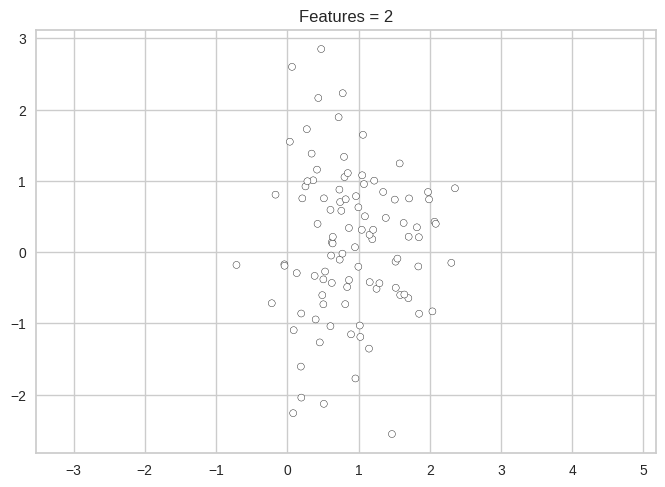

In [5]:
n_features = 2
n_classes = 1
plt.title(f'Features = {n_features}',fontsize='medium')
X1, Y1 = make_classification(n_features = n_features, n_redundant=0, n_informative=1, n_clusters_per_class=1, n_classes=n_classes)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=25, edgecolor='k');
class_df = pd.DataFrame(X1,Y1).reset_index(drop=True)
class_df = class_df.rename(columns={0: 'feature1', 1: 'feature2'})
plt.axis('equal');

In [6]:
X1.shape, Y1.shape

((100, 2), (100,))

In [7]:
class_df.head()

,feature1,feature2
0,1.220123,1.001621
1,1.585253,-0.603717
2,0.625684,0.137689
3,0.211202,0.752992
4,0.514683,0.753488


In [8]:
scaler = StandardScaler()
scaler.fit(class_df)
scaled_df = pd.DataFrame(scaler.transform(class_df))

In [9]:
pca_transformer = PCA(n_components=2)
fitted_pca = pca_transformer.fit(class_df)
fitted_pca.explained_variance_ratio_

array([0.73150808, 0.26849192])

In [10]:
pca_df = pd.DataFrame(fitted_pca.transform(class_df))
pca_df = pca_df.rename(columns={0: 'pc1', 1: 'pc2'})
pca_df.head()

,pc1,pc2
0,0.875166,0.316767
1,-0.731441,0.676276
2,0.013320,-0.280692
3,0.630070,-0.693019
4,0.629504,-0.389538


In [11]:
fitted_pca.explained_variance_ratio_

array([0.73150808, 0.26849192])

<a id=prepare></a> 
## 2 - Preparing the data

<div class="discussion"><b>Discussion:</b> To scale or not to scale? Depends</div>
    
- For more read: "[Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)"

- `Sklearn's` [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

<a id=distance></a> 
## 3 - Distance and dissimilarity metrics

The *Euclidean norm* (or length) of a vector $\textbf{v}=[v_1,v_2,..,v_n]^T$ in $\mathbb{R}^n$ is the nonnegative scalar 
\begin{aligned}
\lVert \textbf{v} \rVert = \sqrt{\textbf{v}\cdot \textbf{v}} = \sqrt{{v_1}^2+{v_2}^2+\cdots+{v_n}^2}
\end{aligned}

The *Manhattan norm* of the same vector is the nonnegative scalar 
\begin{aligned}
\lVert \textbf{v} \rVert = \lvert \textbf{v} \rvert = \lvert v_1 \rvert + \lvert v_2 \rvert + \cdots + \lvert v_n \rvert
\end{aligned}

The distance between two vectors $\textbf{v}$ and $\textbf{u}$ is defined by $d(\textbf{v}, \textbf{u}) = \lVert \textbf{v} - \textbf{u} \rVert$

Let's practice on the diagram below; we are concerned with measuring the distance between two points, $\textbf{p}=(p_1,p_2)$ and $\textbf{q}=(q_1,q_2)$.

<center>
<img src="../images/manhattan_distance.svg" width="250">(edited from Wikipedia.org)
</center>

### Euclidean distance:

The Euclidean distance measures the shortest path between the two points, navigating through all dimensions:

$d(\textbf{p}, \textbf{q}) = \lVert \textbf{p} - \textbf{q} \rVert = \sqrt{{(p_1-q_1)}^2+{(p_2-q_2)}^2}$

For vectors in $\mathbb{R}^n$: 

$d(\textbf{p}, \textbf{q}) = \lVert \textbf{p} - \textbf{q} \rVert = \sqrt{{(p_1-q_1)}^2+{(p_2-q_2)}^2+\cdots +{(p_n-q_n)}^2}$

### Manhattan distance:

The Manhattan distance measures the cumulative difference between the two points, across all dimensions.

$d_1(\textbf{p}, \textbf{q}) = \lVert \textbf{p} - \textbf{q} \rVert_1 = \sum_{i=1}^{n} \mid p_i-q_1 \mid$

### Extra: Cosine distance 

$\cos{\theta} = \frac{\textbf{q}\textbf{q}}{\lVert \textbf{p}\rVert \lVert\textbf{q} \rVert} $

In [12]:
count_vect = CountVectorizer()
sent0= "Biden is here"
sent1= "President is coming here"

corpus = [sent0,sent1]

sentences = count_vect.fit_transform(corpus)
v1 = sentences.toarray()[0]
v2 = sentences.toarray()[1]
print(f'v1 = {v1}, \nv2 = {v2}')
# pretty print
df = pd.DataFrame(sentences.toarray(), \
             columns=count_vect.get_feature_names_out(),index=['Sentence 0','Sentence 1'])
print(f'distance = {distance.cosine(v1, v2)}')
df

v1 = [1 0 1 1 0], 
v2 = [0 1 1 1 1]
distance = 0.42264973081037416


,biden,coming,here,is,president
Sentence 0,1,0,1,1,0
Sentence 1,0,1,1,1,1


**Note**: Normally cosine value=0 means that the two vectors are orthogonal to each other. `scipy` implements `cosine` as `1-cosine`, so `cosine=0` means no connection and `cosine=1` means orthogonal. Cosine metric is used in Collaborative Filtering (Recommender systems for movies). 

### Hamming Distance (extra):

If our two elements of comparison can be represented a sequence of discrete items, it can be useful to measure how many of their elements differ. 

For example:
- `Mahmoud` and `Mahmood` differ by just 1 character and thus have a hamming distance of 1.
- `10101` and `01101` have a hamming distance of 2.
- `Mary` and `Barry` have a hamming distance of 3 (m->b, y->r, null->y).

**Note**: the last example may seem sub-optimal, as we could transform Mary to Barry by just 2 operations (substituting the M with a B, then adding an 'r'). So, their so-called *edit distance* is smaller than their Hamming distance. The very related **Levenshtein distance** [here](https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0) can handle this, and thus tends to be more appropriate for Strings.

<a id=clustering></a> 
## 4 - Clustering Algorithms

<br>

<div class="exercise"><b>Question:</b> Why do we care about clustering? How/why is it useful?</div>

<br>

<center>
<img src="../images/spotify_dailymix.png">
</center>

We will now walk through three clustering algorithms, first discussing them at a high-level, then showing how to implement them with Python libraries. Let's first load and scale our data, so that particular dimensions don't naturally dominate in their contributions in the distant calculations:

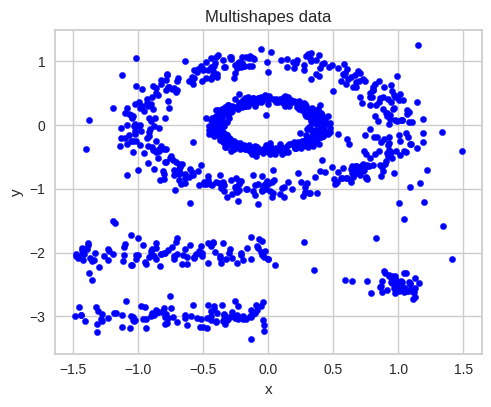

,x,y
0,-0.803739,-0.853053
1,0.852851,0.367618
2,0.927180,-0.274902
3,-0.752626,-0.511565
4,0.706846,0.810679


In [13]:
multishapes = pd.read_csv("../data/multishapes.csv")
ms_df = multishapes[['x','y']]
ms_df.plot.scatter(x='x',y='y',c='Blue',\
                            title="Multishapes data",\
                            figsize=(5.5,4.2))
plt.show()
ms_df.head()

In [14]:
# displays our summary statistics of our data
ms_df.describe()

,x,y
count,1100.000000,1100.000000
mean,-0.081222,-0.625431
std,0.644967,1.176170
min,-1.489180,-3.353462
25%,-0.478839,-1.126752
50%,-0.132920,-0.297040
75%,0.366072,0.250817
max,1.492208,1.253874


In [15]:
scaler = StandardScaler()
scaler = scaler.fit(ms_df)
print(scaler.mean_)
scaled_df = scaler.transform(ms_df)

###### if I had a test set I would transform here:
# test_scaled_df = scaler.transform(test_df)
##################################################

scaled_df = pd.DataFrame(scaled_df, \
                         index=multishapes['shape'], columns = ms_df.columns)
scaled_df.describe()

[-0.08122171 -0.6254313 ]


,x,y
count,1.100000e+03,1100.000000
mean,4.521636e-17,0.000000
std,1.000455e+00,1.000455
min,-2.183985e+00,-2.320473
25%,-6.167723e-01,-0.426425
50%,-8.019252e-02,0.279331
75%,6.938298e-01,0.745340
max,2.440659e+00,1.598544


#### Very important reminder!! 

If you have a training and a test set, always `.fit()` your scaler only to the training set, and then`.transform()` both sets.  

#### Let's plot this data with and without scaling

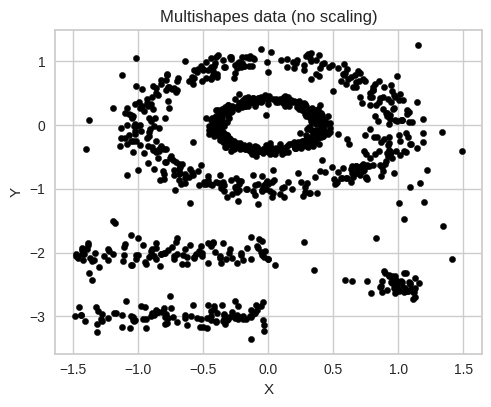

In [16]:
# plot our data
msplot = ms_df.plot.scatter(x='x',y='y',c='Black',\
                            title="Multishapes data (no scaling)",\
                            figsize=(5.5,4.2))
msplot.set_xlabel("X")
msplot.set_ylabel("Y")
plt.show()

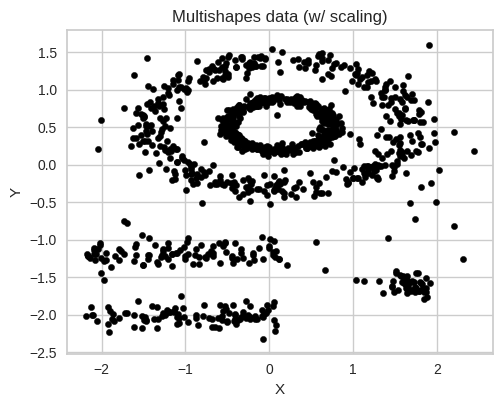

In [17]:
# plots our data
msplot = scaled_df.plot.scatter(x='x',y='y',c='Black',\
                                title="Multishapes data (w/ scaling)",\
                                figsize=(5.5,4.2))
msplot.set_xlabel("X")
msplot.set_ylabel("Y")
plt.show()

## 3a. $k$-Means clustering:

#### Code (via `sklearn`):

In [18]:
ms_kmeans = KMeans(n_clusters=4, init='random', n_init=3, random_state=109)
ms_kmeans.fit(scaled_df)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'random'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",3
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",109
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


Now that we've run k-means, we can look at various attributes of our clusters. Full documenation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [19]:
display(ms_kmeans.cluster_centers_)
display(ms_kmeans.labels_[0:1000])


array([[ 1.64888377, -1.46066772],
       [-0.51561901,  0.5057667 ],
       [ 0.91292769,  0.51636922],
       [-0.98436965, -1.5817027 ]])

array([1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2,
       1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1,

### Plotting
Take note of matplotlib's `c=` argument to color items in the plot, along with our stacking two different plotting functions in the same plot.

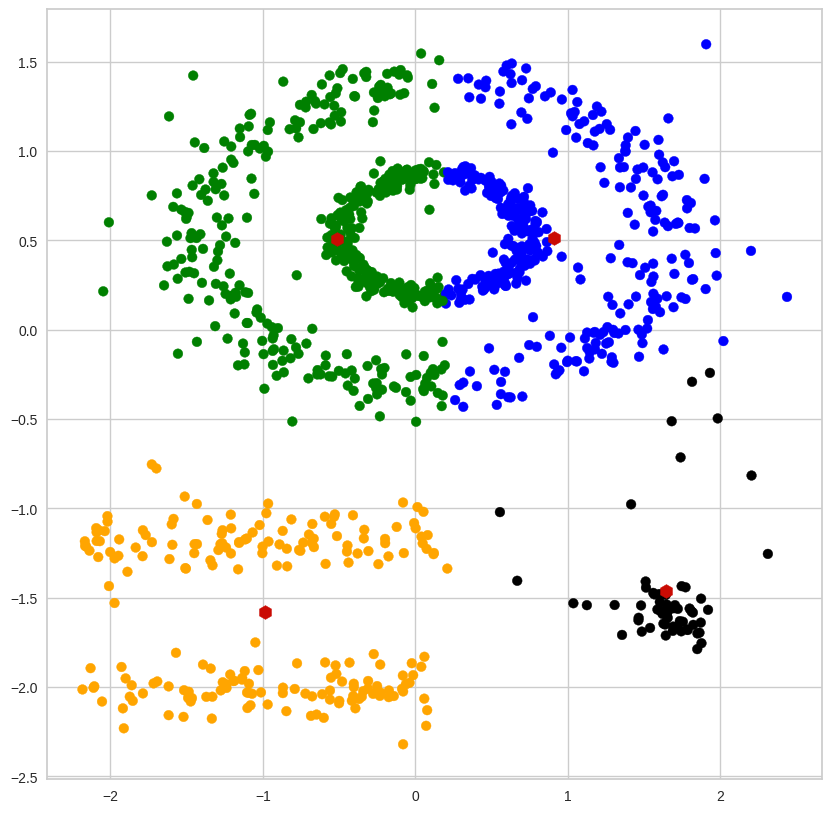

In [20]:
plt.figure(figsize=(10,10))
# ms_kmeans label colors : black for 0 , green for 1, blue for 2, red for 3
colors = ['black' if label == 0 else 'green' if label == 1 else 'blue' if label == 2 else 'orange' for label in ms_kmeans.labels_]
plt.scatter(scaled_df['x'],scaled_df['y'], c=colors)
plt.scatter(ms_kmeans.cluster_centers_[:,0],ms_kmeans.cluster_centers_[:,1], c='r', marker='h', s=100)

## Quality of Clusters

### A - Inertia
Inertia measures the total squared distance from points to their cluster's centroid. We obviously want this distance to be relatively small. If we increase the number of clusters, it will naturally make the average distance smaller. If every point has its own cluster, then our distance would be 0. That's obviously not an ideal way to cluster. One way to determine a reasonable number of clusters to simply try many different clusterings as we vary **k**, and each time, measure the overall inertia.

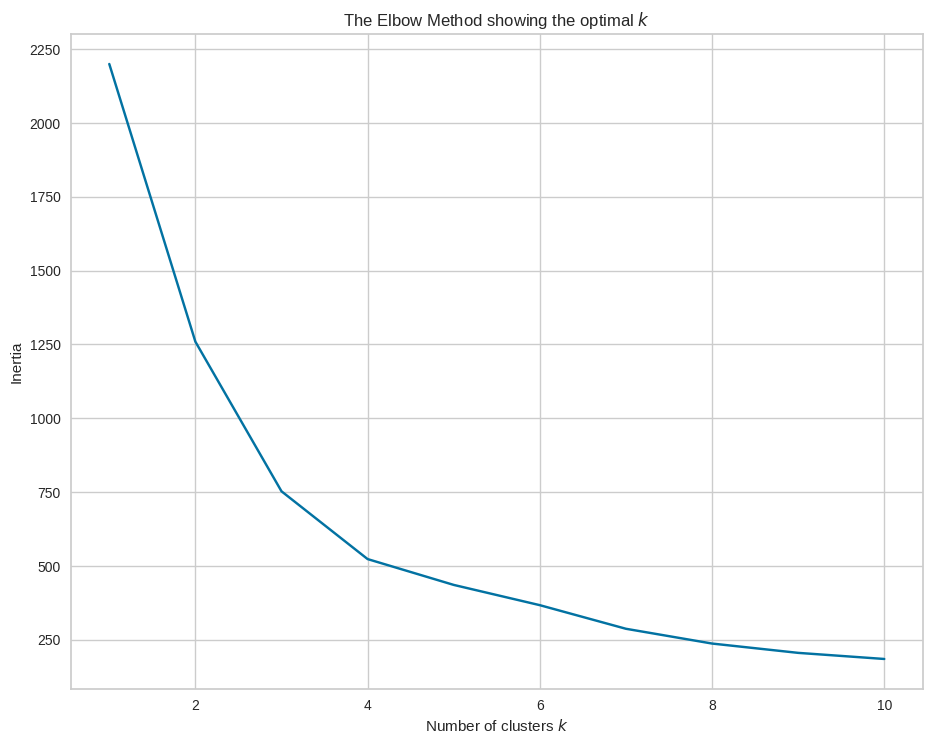

In [21]:
wss = []
for i in range(1,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

Look for the place(s) where distance stops decreasing as much (i.e., the 'elbow' of the curve). It seems that 4 would be a good number of clusters, as a higher *k* yields diminishing returns.

<div class="exercise"><b>Exercise</b>: Run K-means again with 4 clusters this time. </div>

### B - Silhouette

Let's say we have a data point $i$, and the cluster it belongs to is referred to as $C(i)$. One way to measure the quality of a cluster $C(i)$ is to measure how close its data points are to each other (within-cluster) compared to nearby, other clusters $C(j)$. This is what `Silhouette Scores` provide for us. The range is [-1,1]; 0 indicates a point on the decision boundary (equal average closeness to points intra-cluster and out-of-cluster), and negative values mean that datum might be better in a different cluster.

Specifically, let $a(i)$ denote the average distance data point $i$ is to the other points in the same cluster:

<center>
<img src="../images/silhouette_intra.png">
</center>

Similarly, we can also compute the average distance that data point $i$ is to all **other** clusters. The cluster that yields the minimum distance is denoted by $b(i)$:  

<center>
<img src="../images/silhouette_outer.png">
</center>

Hopefully our data point $i$ is much closer, on average, to points within its own cluster (i.e., $a(i)$ than it is to its closest neighboring cluster $b(i)$). The silhouette score quantifies this as $s(i)$:

<center>
<img src="../images/silhouette_eq.png">
</center>

**NOTE:** If data point $i$ belongs to its own cluster (no other points), then the silhouette score is set to 0 (otherwise, $a(i)$ would be undefined).

The silhouette score plotted below is the **overall average** across all points in our dataset.

The `silhouette_score()` function is available in `sklearn`. We can manually loop over values of K (for applying k-Means algorithm), then plot its silhouette score.

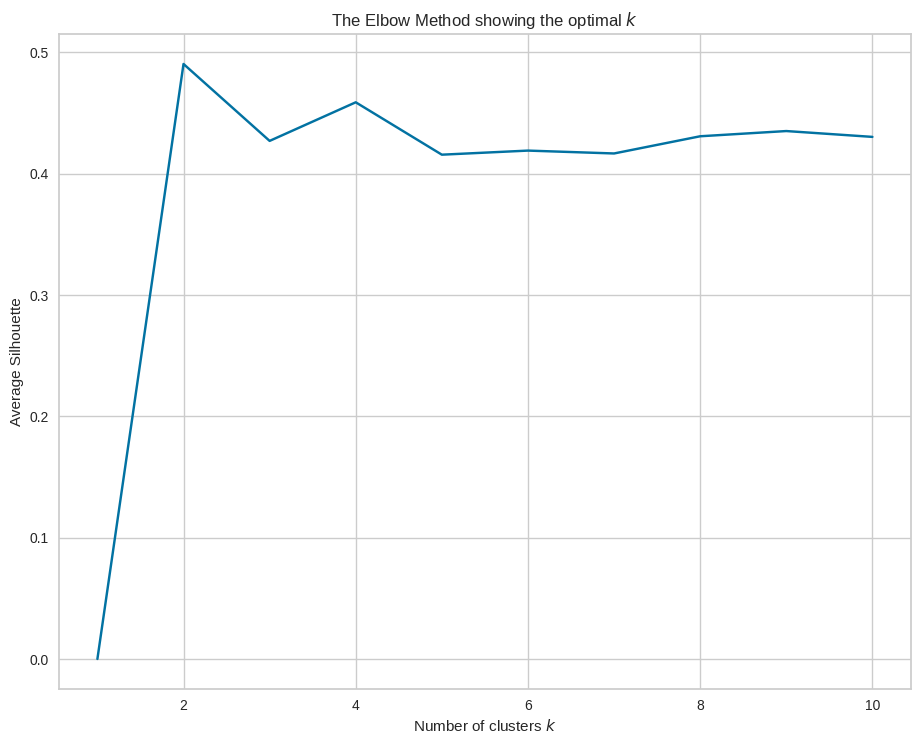

In [22]:
scores = [0]
for i in range(2,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=46, random_state=109).fit(scaled_df)
    score = silhouette_score(scaled_df, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

### Visualizing all Silhoutte scores for a particular clustering

Below, we borrow from an `sklearn` example. The second plot may be overkill.
 - The second plot is just the scaled data. It is *not* a PCA plot
 - If you only need the raw silhouette scores, use the `silhouette_samples()` function

In [23]:
# modified code from 
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 4, the average silhouette_score is 0.4575264083610932.


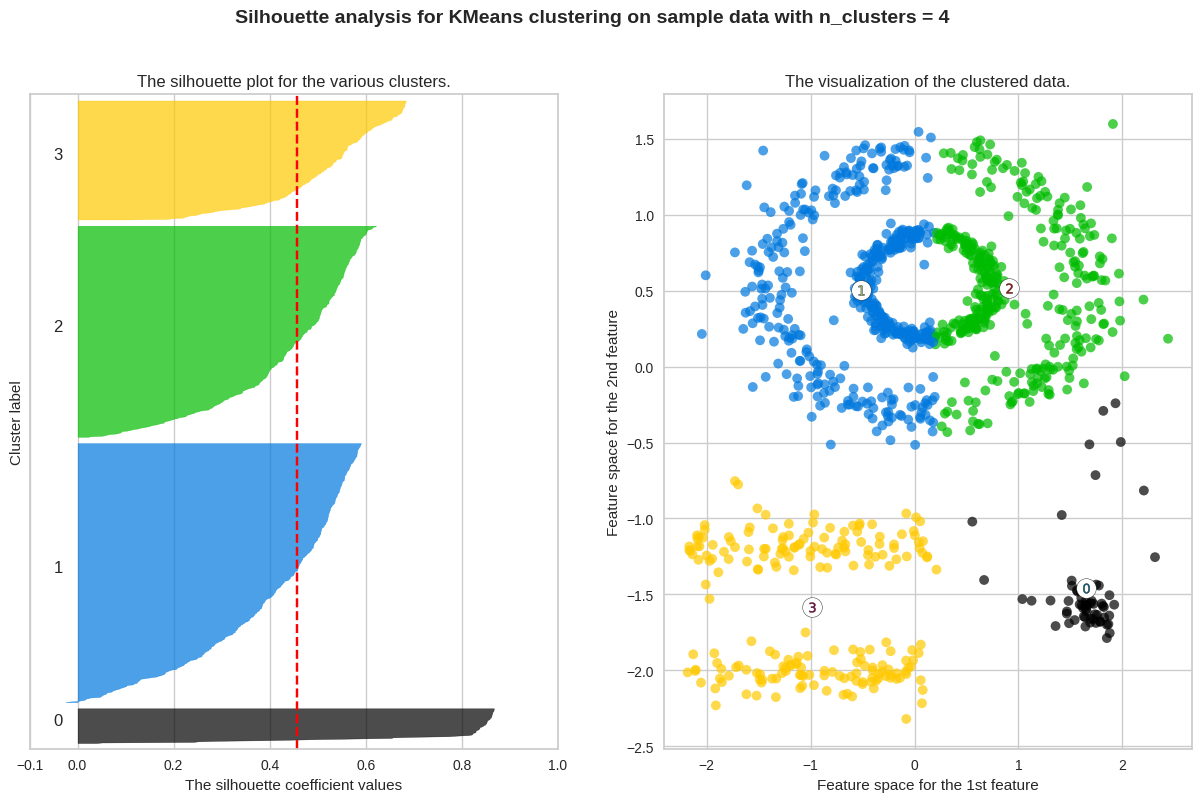

In [24]:
ms_kmeans = KMeans(n_clusters=4, init='random', n_init=3, random_state=109).fit(scaled_df)

# plot a fancy silhouette plot
silplot(scaled_df.values, ms_kmeans)

### C - Gap Statistic

The gap statistic compares within-cluster distances (such as in silhouette), but instead of comparing against the second-best existing cluster for that point, it compares our clustering's overall average to the average we'd see if the data were generated at random (we'd expect randomly generated data to not necessarily have any inherit patterns that can be easily clustered). 

In essence, the within-cluster distances (in the elbow plot) will go down just becuse we have more clusters. We additionally calculate how much they'd go down on non-clustered data with the same spread as our data and subtract that trend out to produce the plot below.

The original paper is : "[Estimating the number of clusters in a data set via the gap statistic](https://statweb.stanford.edu/~gwalther/gap)" (Tibshirani et al.).

As suggested in the paper, we would choose the value of $\hat{k}$ (number of clusters) such that <BR><BR>
$\hat{k}$ = smallest $k$ such that Gap($k$) $\geq$ Gap($k+1$) - $s_{k+1}$. 
<BR><BR>
We compare the **actual Gap value** of the `k` point to the **lower bar** of the Gap value of the `k+1` point. The following graph should make it clearer. The plot is from the original paper (Fig. 2) (dashed lines are mine) <BR><BR>
<center>
<img src="../images/gapstat.jpg" width="500px">
</center>
<BR><BR>
We could argue that we should have chosen the largest value (k =3) instead of the first value that satisfies the Gap statistic equation (k=1 in this case). If you're able to compute for a range of k, then you can choose the maximum. For example, in the graph above, since we're computing over k=1,..,10, we could choose k=3. The original paper although it suggests that we look at the whole range, chooses k=1 in the case above; if you see the raw data plotted (Fig. 2 in the paper) you will also notice that there is really not much structure for cluster subdivision but we should always investigate the whole plot. Also, it's very computationally intensive to compute the Gap statistic. 
Additionally, you can use domain knowledge or whatever information you have about the data to choose k. 
<BR><BR>
The gap statistic is implemented by Miles Granger in the `gap_statistic`(https://github.com/milesgranger/gap_statistic) Python library. The library also implements the Gap$^*$ statistic described in "A comparison of Gap statistic definitions with and with-out logarithm function(https://core.ac.uk/download/pdf/12172514.pdf)" (Mohajer, M., Englmeier, K. H., & Schmid, V. J., 2011) which is less conservative but tends to perform suboptimally when clusters overlap.

### Generating synthetic data again

,0,1
2,-3.227277,1.912233
3,-7.737438,6.009425
2,-3.935534,1.959327
3,-6.106352,4.370921
1,5.505194,-6.955718


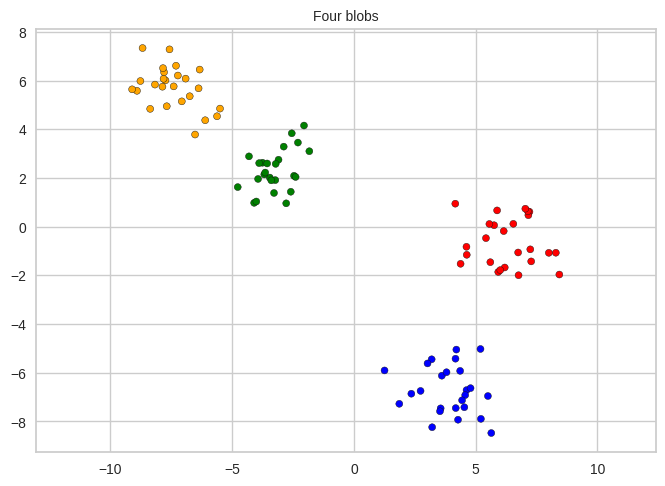

In [25]:
plt.title("Four blobs", fontsize='small')
X1, Y1 = make_blobs(n_features=2, centers=4) # centers is number of classes
# colorize the 4 blobs using Y1 labels
colors_blobs = ['red', 'blue', 'green', 'orange']
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=[colors_blobs[i] for i in Y1], s=25, edgecolor='k')
blob_df = pd.DataFrame(X1,Y1)
plt.axis('equal')
blob_df.head()

Optimal number of clusters by silhouette score: 4


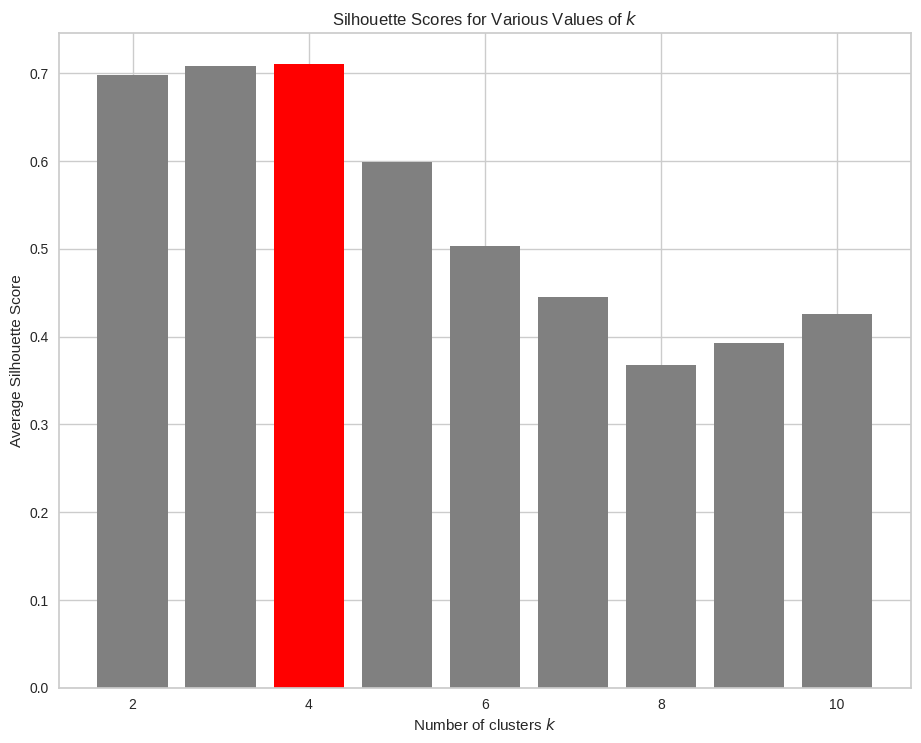

In [26]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(X1)
    score = silhouette_score(X1, km.labels_)
    scores.append(score)

# Optimal K is the index of the max score + 2
optimal_k = max(range(len(scores)), key=scores.__getitem__) + 2
print(f'Optimal number of clusters by silhouette score: {optimal_k}')

colorize = ['red' if i == max(range(len(scores)), key=scores.__getitem__) else 'gray' for i in range(len(scores))]
plt.figure(figsize=(11,8.5))
plt.bar(range(2, 11), scores, color=colorize)
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores for Various Values of $k$')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6980242868643838
For n_clusters = 3 The average silhouette_score is : 0.7080886469121829
For n_clusters = 4 The average silhouette_score is : 0.7101052989172993
For n_clusters = 5 The average silhouette_score is : 0.6431421468970953
For n_clusters = 6 The average silhouette_score is : 0.5551086984158904


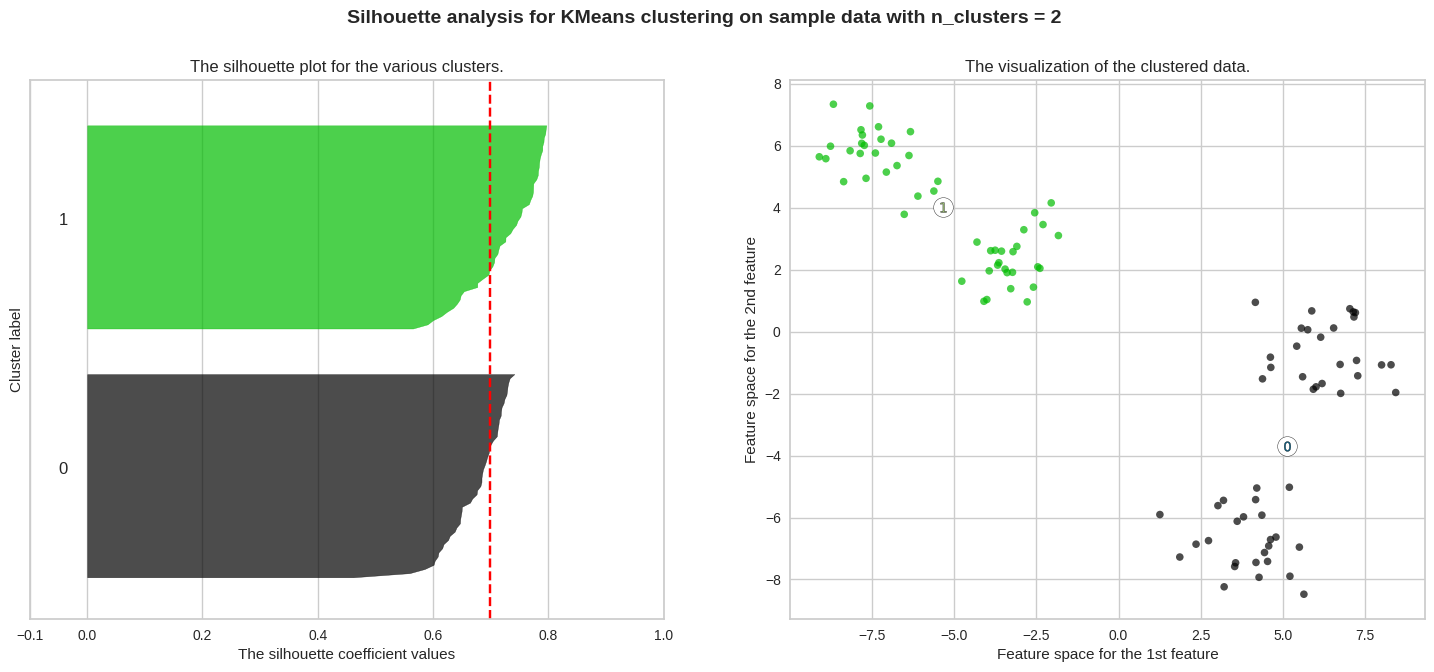

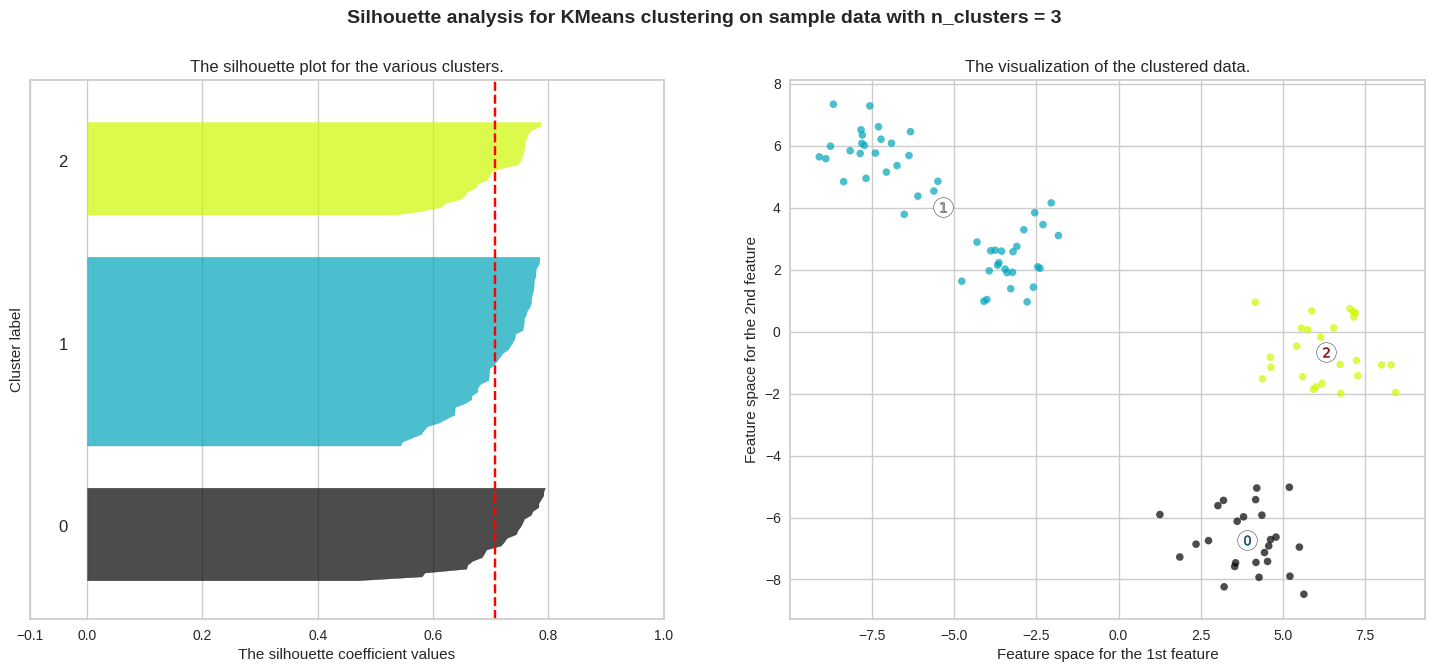

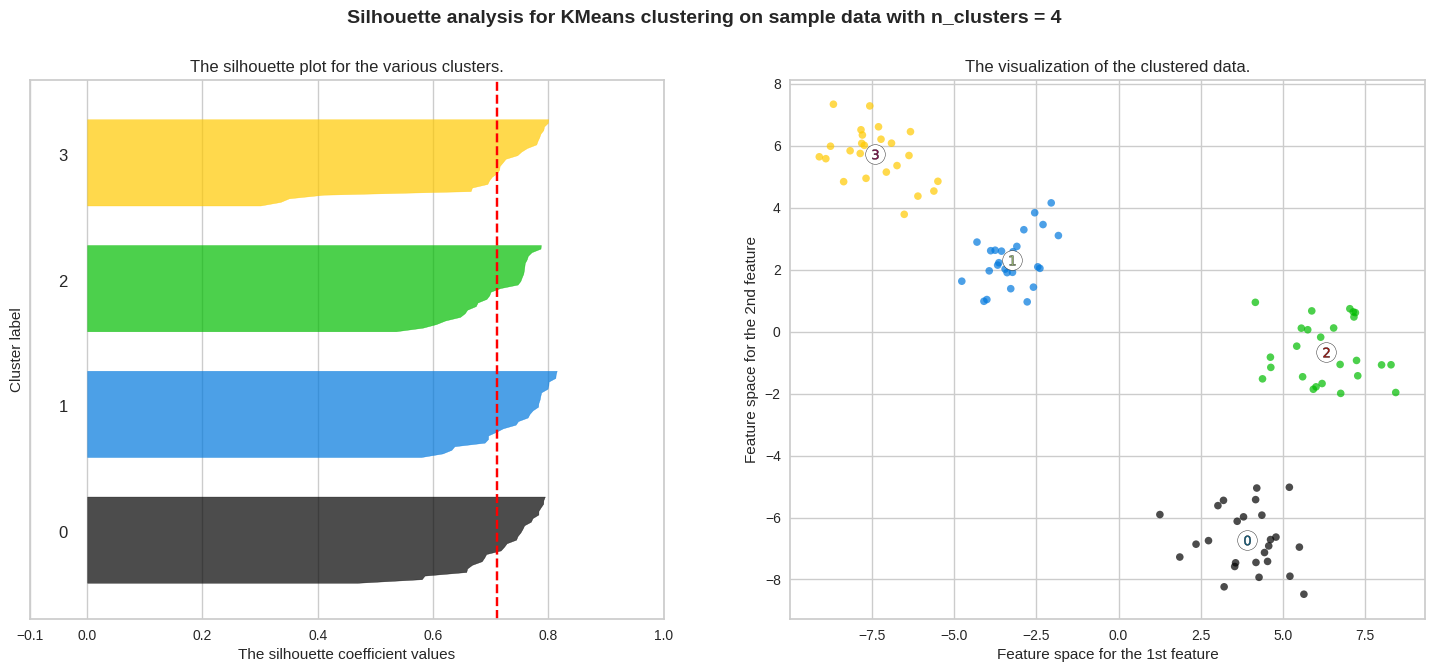

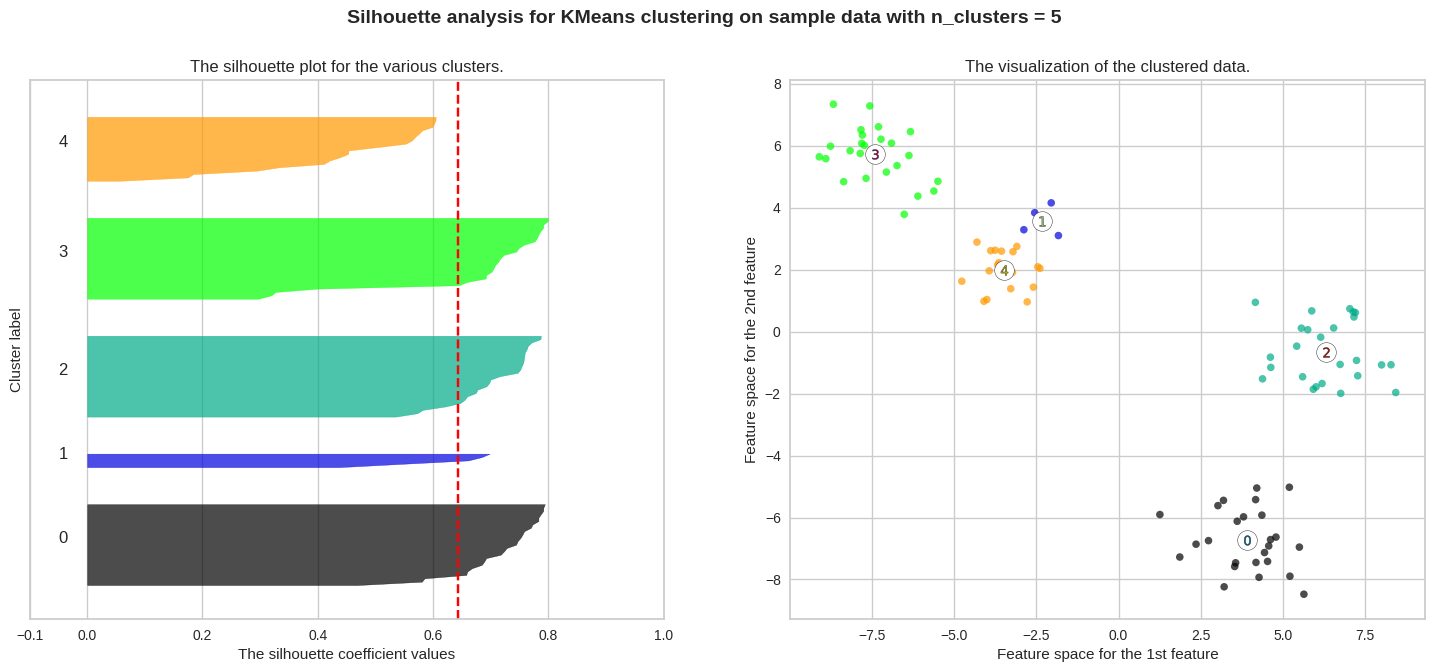

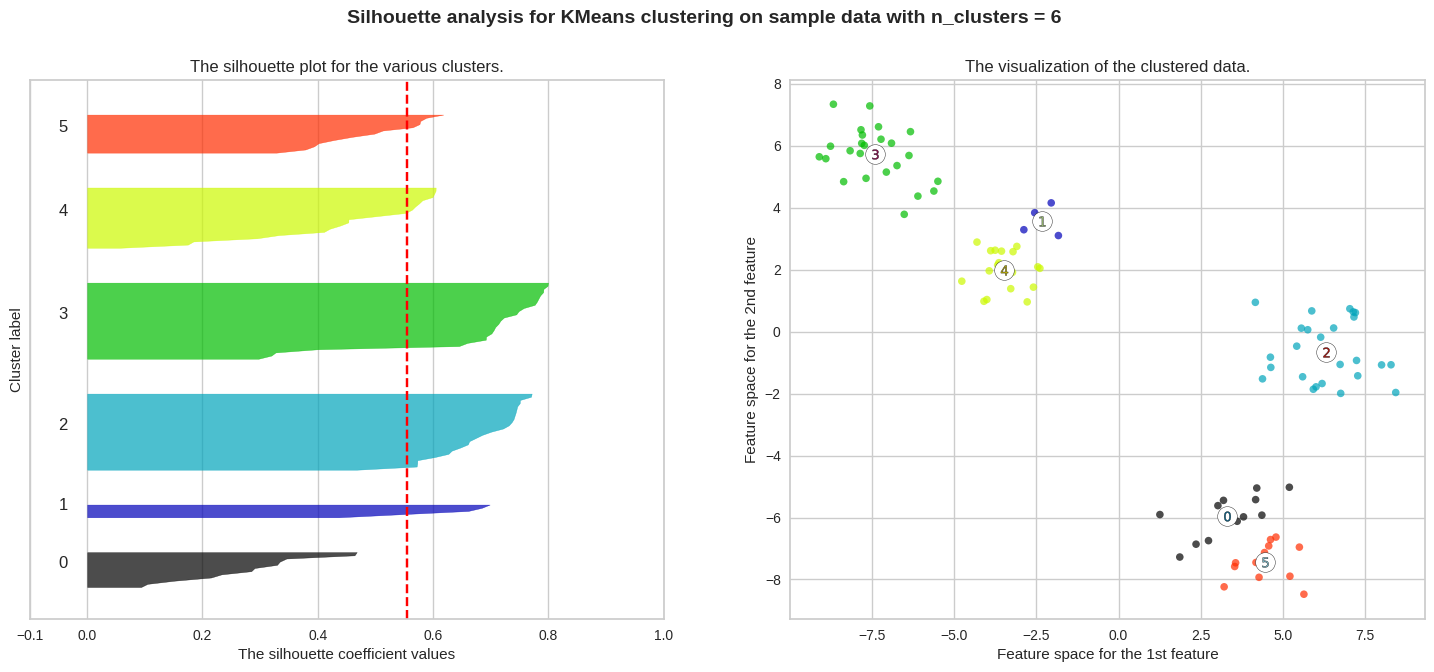

In [27]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

# reset the features to match previously generated blobs
X, y = X1, Y1

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

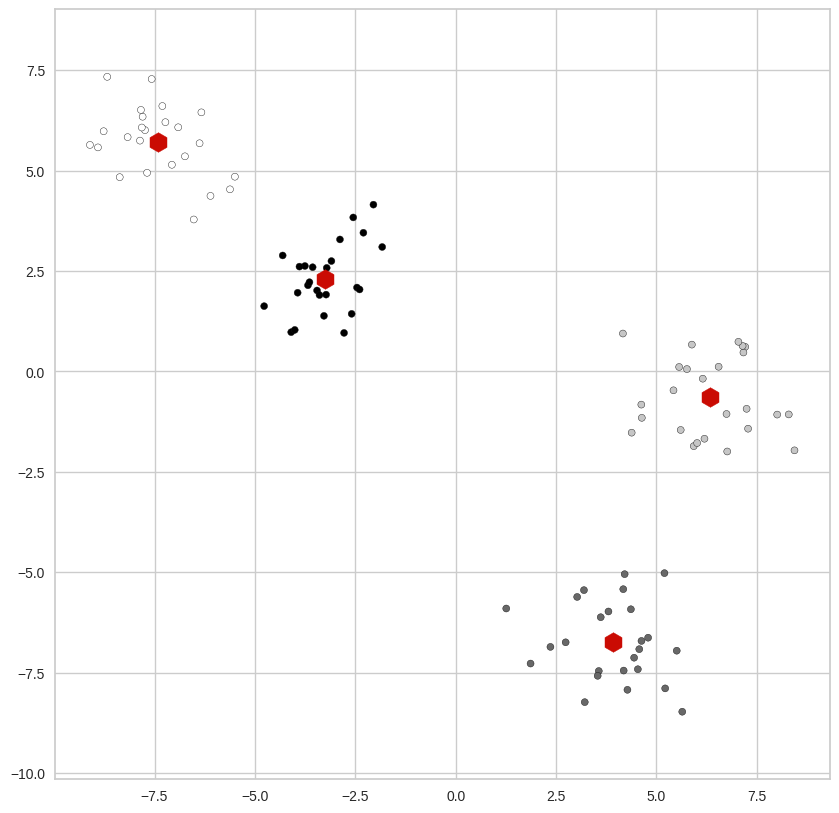

In [28]:
ms_kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=3, random_state=109).fit(X1)
plt.figure(figsize=(10,10))

# update the values of Y1 to optimal_k clusters
Y1 = ms_kmeans.labels_

plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=25, edgecolor='k')
plt.scatter(ms_kmeans.cluster_centers_[:,0], ms_kmeans.cluster_centers_[:,1], c='r', marker='h', s=200)
plt.axis('equal');

## 3b. Agglomerative Clustering


#### Code (via `scipy`):

There are many different cluster-merging criteria, one of which is Ward's criteria. Ward's optimizes having the lowest total within-cluster distances, so it merges the two clusters that will harm this objective least.
`scipy`'s agglomerative clustering function implements Ward's method.

In [29]:
USArrests = pd.read_csv('../data/USArrests2.csv')

In [30]:
df = USArrests[['SexualAssault','Assault','UrbanPop', 'Homicide']]
arrests_scaled = pd.DataFrame(preprocessing.scale(df), index=USArrests['State'], columns = df.columns)

### Understanding the notion of a vector (data) matrix and a distance or dissimilarity matrix

In [31]:
# data matrix
# display observation 3, 15, and 40 along with columns lables
df.iloc[[3,15,40]]
# show index labels 'State' values along with columns lables
#USArrests['State'].iloc[[3,15,40]]


,SexualAssault,Assault,UrbanPop,Homicide
3,19.5,190,50,8.8
15,18.0,115,66,6.0
40,12.8,86,45,3.8


In [32]:
# distance matrix
from sklearn.metrics import pairwise_distances
pairwise_distances(df.iloc[[3,15,40]], metric='euclidean')

array([[  0.        ,  76.75343641, 104.45520571],
       [ 76.75343641,   0.        ,  36.24748267],
       [104.45520571,  36.24748267,   0.        ]])

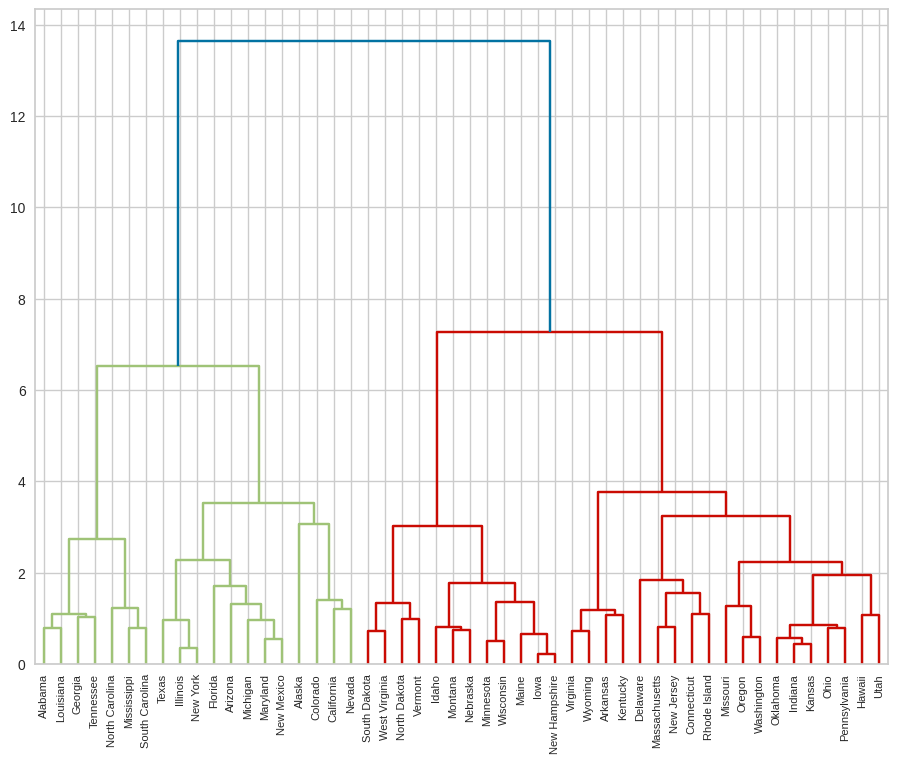

In [33]:
# import scipy.cluster.hierarchy as hac
plt.figure(figsize=(11,8.5))
dist_mat = pdist(arrests_scaled, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data, labels=USArrests["State"].values);
plt.show()

<div class="discussion"><b>Discussion</b>: How do you read a plot like the above? What are valid options for number of clusters, and how can you tell? Are some more valid than others? </div>

### Lessons:
 - It's expensive: $O(n^3)$ time complexity and $O(n^2)$ space complexity.
 - Many choices for linkage criteria
 - Every node gets clustered (no child left behind)

#### Example of the use of hierarchical clustering as an exploratory tool

Clustering our data in a hierarchical way can reveal associations between them. We can exploit those associations later in the model.
<BR>
<BR>
<center>
<img src="../images/dendrogram_ward_sm.png" width="800px">
</center>

## 3c. DBSCAN Clustering
DBSCAN uses an intuitive notion of denseness to define clusters, rather than defining clusters by a central point as in k-means.

### Code (via `sklearn`):
DBscan is implemented in `sklearn`, but there aren't great automated tools for searching for the optimal `epsilon` parameter. For full documentation, please [visit this page](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

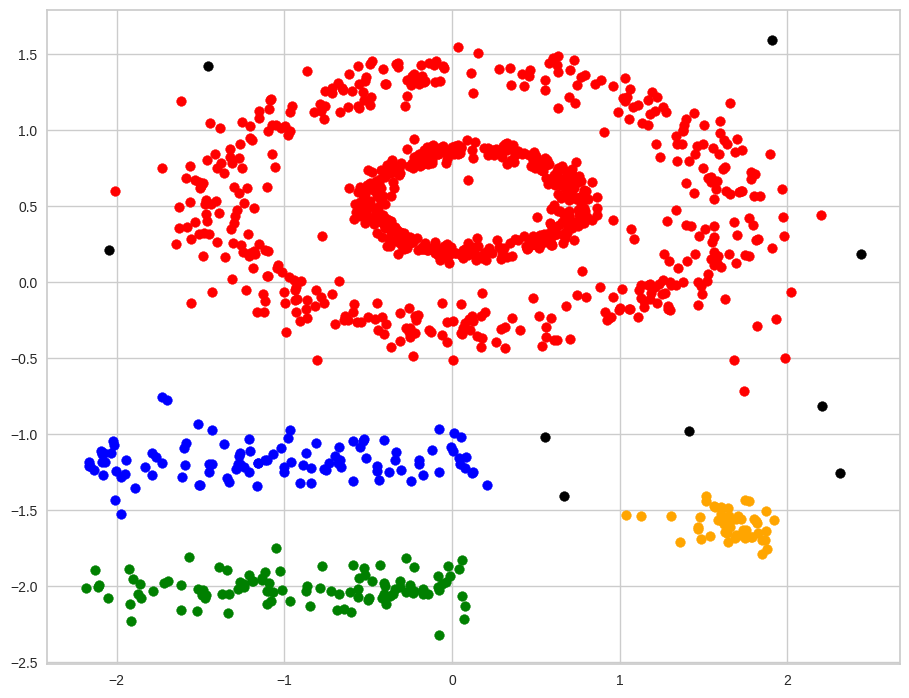

In [34]:
plt.figure(figsize=(11,8.5))
fitted_dbscan = DBSCAN(eps=0.34, min_samples=5).fit(scaled_df)
# plot the clusters with different bright colors and noise points in black
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for i, label in enumerate(set(fitted_dbscan.labels_)):
    if label == -1:
        plt.scatter(scaled_df['x'][fitted_dbscan.labels_ == label], scaled_df['y'][fitted_dbscan.labels_ == label], c='black')
    else:
        plt.scatter(scaled_df['x'][fitted_dbscan.labels_ == label], scaled_df['y'][fitted_dbscan.labels_ == label], c=colors[i % len(colors)])


#plt.scatter(scaled_df['x'],scaled_df['y'], c=fitted_dbscan.labels_);

**Note:** the black dots are not clustered with anything else. They are lone singletons. You can validate such by setting epsilon to a very small value, and increase the min_samples to a high value. Under these conditions, nothing would cluster, and yet all dots become dark purple.

<br>

<div class="exercise"><b>Exercise</b>: Experiment with the above code by changing its epsilon value and the min_samples (what is the default value for it, since the above code doesn't specify a value?)</div>

### Lessons:
 - Can cluster non-linear relationships very well; potential for more natural, arbritrarily shaped groupings
 - Does not require specifying the # of clusters (i.e., **k**); the algorithm determines such
 - Robust to outliers
 - Doesn't guarantee that every (or ANY) item will be clustered
 
<br>

<a id=images></a>   
## 5. Extra: Clustering for images

<div class="exercise"  ><b>Breakroom Exercise</b>: Let's load the MNIST digits and try to use k-means to cluster them.</div>


In [35]:
digits = load_digits()
print(digits.data.shape, digits.images.shape, digits.target.shape)

(1797, 64) (1797, 8, 8) (1797,)


<Figure size 800x550 with 0 Axes>

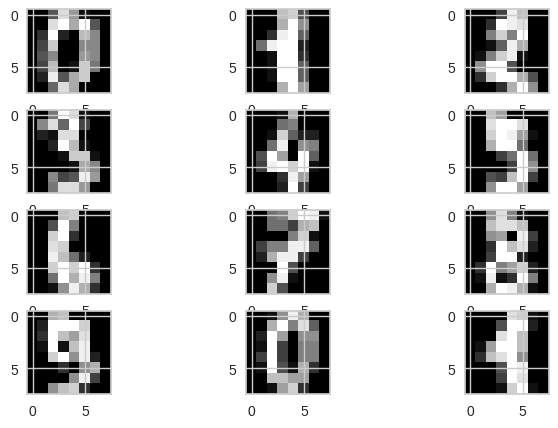

In [36]:
plt.gray() 
plt.figure(figsize = (8,5)) 

for i in range(12):
    plt.subplot(4,3,i+1);
    plt.imshow(digits.images[i]);

In [37]:
scaler = StandardScaler()
scaler.fit(digits.data)
digits_scaled = scaler.transform(digits.data)

In [38]:
digits_scaled.shape

(1797, 64)

In [39]:
# print the first 5 rows of the scaled data with column labels
digits_scaled_df = pd.DataFrame(digits_scaled, columns=digits.feature_names)
digits_scaled_df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,-0.335016,-0.043081,0.274072,-0.664478,-0.844129,-0.409724,-0.125023,-0.059078,-0.624009,...,-0.757436,-0.209785,-0.023596,-0.299081,0.086719,0.208293,-0.366771,-1.146647,-0.505670,-0.196008
1,0.0,-0.335016,-1.094937,0.038648,0.268751,-0.138020,-0.409724,-0.125023,-0.059078,-0.624009,...,-0.757436,-0.209785,-0.023596,-0.299081,-1.089383,-0.249010,0.849632,0.548561,-0.505670,-0.196008
2,0.0,-0.335016,-1.094937,-1.844742,0.735366,1.097673,-0.409724,-0.125023,-0.059078,-0.624009,...,0.259230,-0.209785,-0.023596,-0.299081,-1.089383,-2.078218,-0.164037,1.565686,1.695137,-0.196008
3,0.0,-0.335016,0.377661,0.744919,0.268751,-0.844129,-0.409724,-0.125023,-0.059078,1.879691,...,1.072563,-0.209785,-0.023596,-0.299081,0.282736,0.208293,0.241430,0.379040,-0.505670,-0.196008
4,0.0,-0.335016,-1.094937,-2.551014,-0.197863,-1.020657,-0.409724,-0.125023,-0.059078,-0.624009,...,-0.757436,-0.209785,-0.023596,-0.299081,-1.089383,-2.306869,0.849632,-0.468564,-0.505670,-0.196008


In [180]:
# fit the data to KMeans with 10 clusters and random initialization
n_digits = 10
n_init = 1
init = "random"
kmeans = KMeans(init=init, n_clusters=n_digits, n_init=n_init, random_state=22)
kmeans.fit(digits_scaled)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",10
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'random'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",1
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",22
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [178]:
# inititalize cluster dict
clusters = {}
for i in range(n_digits):
    clusters[i] = [] 
clusters

# assign the true labels to the clusters based on kmeans labels
for idx, j in enumerate(kmeans.labels_):
    clusters[j].append(digits.target[idx])

# Check out the cluster quality manually
for num in range(10):
    df = pd.Series(clusters[num])
    print(f'Cluster = {num}')
    print(df.value_counts())

Cluster = 0
7    159
9     10
3      6
4      5
8      2
5      1
2      1
Name: count, dtype: int64
Cluster = 1
5    134
3      6
8      5
9      4
4      1
Name: count, dtype: int64
Cluster = 2
8    101
1     97
2     19
7     12
3      9
6      5
4      3
9      2
5      2
0      1
Name: count, dtype: int64
Cluster = 3
6    173
5      3
8      2
Name: count, dtype: int64
Cluster = 4
2    42
1    27
3     1
6     1
Name: count, dtype: int64
Cluster = 5
0    177
8      1
6      1
Name: count, dtype: int64
Cluster = 6
4    166
5      2
7      1
Name: count, dtype: int64
Cluster = 7
3    155
9    144
8     44
5     40
2      5
Name: count, dtype: int64
Cluster = 8
2    105
8      9
7      7
3      6
Name: count, dtype: int64
Cluster = 9
1    58
9    20
8    10
4     6
2     5
6     1
Name: count, dtype: int64


In [179]:
# compute the general error rate of the clustering by comparing the most common true label in each cluster to the total number of data points in that cluster
total_error = 0
for num in range(10):
    df = pd.Series(clusters[num])
    most_common_label = df.value_counts().idxmax()
    num_most_common = df.value_counts().max()
    error_rate = 1 - (num_most_common / len(df))
    total_error += error_rate * len(df)
    # display error rate as percentage notation with 2 decimal places
    print(f'Cluster {num}: Most common label = {most_common_label}, Error rate in % = {100*error_rate:.2f}') # error rate is the percentage of data points in the cluster that do not belong to the most common true label
print(f'Total error rate in % = {100*total_error / len(digits_scaled):.2f}')
# print overall model accuracy
print(f'Overall model accuracy with n_init={n_init} and init={init} in % = {100*(1 - total_error / len(digits_scaled)):.2f}')


Cluster 0: Most common label = 7, Error rate in % = 13.59
Cluster 1: Most common label = 5, Error rate in % = 10.67
Cluster 2: Most common label = 8, Error rate in % = 59.76
Cluster 3: Most common label = 6, Error rate in % = 2.81
Cluster 4: Most common label = 2, Error rate in % = 40.85
Cluster 5: Most common label = 0, Error rate in % = 1.12
Cluster 6: Most common label = 4, Error rate in % = 1.78
Cluster 7: Most common label = 3, Error rate in % = 60.05
Cluster 8: Most common label = 2, Error rate in % = 17.32
Cluster 9: Most common label = 1, Error rate in % = 42.00
Total error rate in % = 29.33
Overall model accuracy with n_init=1 and init=k-means++ in % = 70.67


In [ ]:
# Best scores with init=k-means++ is with n_init=1 at 70,67% runtime 0.3s
# Best score with init=random is with n_init=1 at 74.46% runtime 0,6s

### References:

[1] [A Tutorial on Principal Component Analysis](https://arxiv.org/pdf/1404.1100.pdf)